In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
#from qiskit.test.mock import FakeAlmaden
#backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
beta, alpha = np.pi/2, np.pi/2

In [7]:
schedules = []

In [8]:
XXX = cmd_def.get('x', qubits=[0]) | cmd_def.get('x', qubits=[1])  | cmd_def.get('x', qubits=[2]) 
schedule = XXX

schedule |= cmd_def.get('u1', qubits=[2], P0=-np.pi/2) << schedule.duration # sdag(2)
HH = cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[2], P0=0, P1=np.pi)
schedule |= HH << schedule.duration

CNOT_RZ_CNOT = cmd_def.get('cx', qubits=[1, 2])
CNOT_RZ_CNOT |= cmd_def.get('u1', qubits=[2], P0=beta) << CNOT_RZ_CNOT.duration
CNOT_RZ_CNOT |= cmd_def.get('cx', qubits=[1, 2]) << CNOT_RZ_CNOT.duration
schedule |= CNOT_RZ_CNOT << schedule.duration

# H and then S on qubit 2
schedule |= cmd_def.get('u2', qubits=[2], P0=0, P1=np.pi) << schedule.duration
schedule |= cmd_def.get('u1', qubits=[2], P0=np.pi/2) << schedule.duration


# Sdag and then H on qubit 0
schedule |= cmd_def.get('u1', qubits=[0], P0=-np.pi/2) << schedule.duration
schedule |= cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) << schedule.duration

# CNOT RZ CNOT on qubits 0, 1
CNOT_RZ_CNOT = cmd_def.get('cx', qubits=[0, 1])
CNOT_RZ_CNOT |= cmd_def.get('u1', qubits=[1], P0=alpha) << CNOT_RZ_CNOT.duration
CNOT_RZ_CNOT |= cmd_def.get('cx', qubits=[0, 1]) << CNOT_RZ_CNOT.duration
schedule |= CNOT_RZ_CNOT << schedule.duration

# H on qubits 0, 1
HH = cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi)
schedule |= HH << schedule.duration

# S on qubit 0
schedule |= cmd_def.get('u1', qubits=[0], P0=np.pi/2)

schedule |= measure << schedule.duration

schedules.append(schedule)

In [9]:
## Optimized Way:
N = 3
circ = q.QuantumCircuit(N)
circ.x(0); circ.x(1); circ.x(2);  # start with |111>

#  exp(-i*beta* X_1 Y_2)
circ.h(1)
circ.sdg(2); circ.h(2)
circ.zz_interaction(beta, 1, 2)
circ.h(2); circ.s(2)

# exp(-i*alpha* Y_0 X_1)
circ.sdg(0); circ.h(0);
circ.zz_interaction(alpha, 0, 1)
circ.h(0); circ.s(0);
circ.h(1)


decomposed_circuit = circ.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration
schedules.append(schedule)

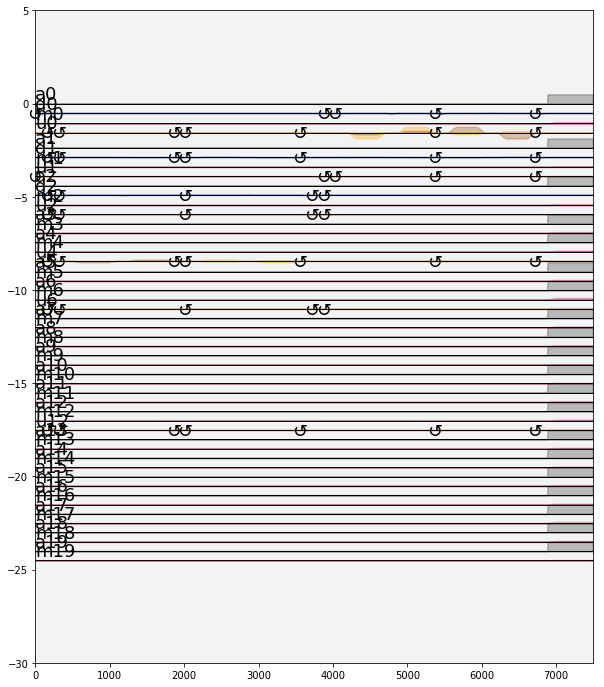

In [10]:
schedules[0].draw(table=False, plot_range=(0, 7500))

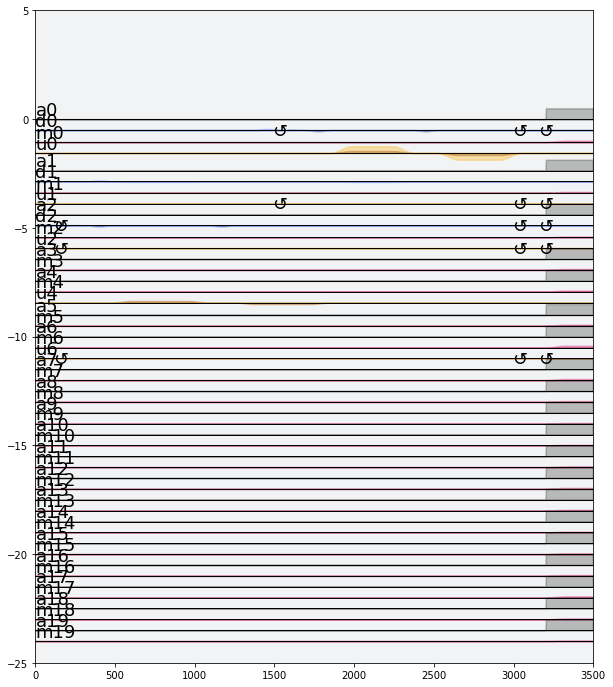

In [11]:
schedules[1].draw(table=False, plot_range=(0, 3500))

In [12]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5ddc89de6b72bd00113d27c1


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [17]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>

# Run a mitigation cal job

In [14]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1,2])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)

In [15]:
job_mit = q.execute(meas_schedules, backend, shots=shots)
print('job_mit is %s' % job_mit.job_id())

job_mit is 5ddc89f72865b20011f575c1


In [16]:
job_mit.status()

<JobStatus.VALIDATING: 'job is being validated'>

-----
## Analysis

In [18]:
from qiskit.result import marginal_counts

In [19]:
result = job.result()

In [20]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1,2])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[9.41750e-01, 7.02500e-02, 7.26250e-02, 8.50000e-03, 5.73750e-02,
        4.62500e-03, 5.00000e-03, 6.25000e-04],
       [2.32500e-02, 8.92250e-01, 2.37500e-03, 7.11250e-02, 1.75000e-03,
        6.03750e-02, 3.75000e-04, 6.50000e-03],
       [1.27500e-02, 1.62500e-03, 8.81750e-01, 8.23750e-02, 2.50000e-03,
        2.50000e-04, 6.21250e-02, 5.87500e-03],
       [2.12500e-03, 1.23750e-02, 2.11250e-02, 8.16250e-01, 0.00000e+00,
        1.37500e-03, 1.37500e-03, 5.32500e-02],
       [1.93750e-02, 1.87500e-03, 3.00000e-03, 1.25000e-04, 8.99375e-01,
        6.96250e-02, 6.93750e-02, 7.25000e-03],
       [6.25000e-04, 2.08750e-02, 3.75000e-04, 3.12500e-03, 2.17500e-02,
        8.53625e-01, 2.75000e-03, 6.88750e-02],
       [1.25000e-04, 1.25000e-04, 1.85000e-02, 1.75000e-03, 1.63750e-02,
        7.50000e-04, 8.40750e-01, 8.86250e-02],
       [0.00000e+00, 6.25000e-04, 2.50000e-04, 1.67500e-02, 8.75000e-04,
        9.37500e-03, 1.82500e-02, 7.69000e-01]])

In [21]:
standard_counts = marginal_counts(result.get_counts(0), [0,1,2])
print('before mitigation:')
print(standard_counts)

standard_counts = readout_fitter.filter.apply(standard_counts)
print('\n\n\n after mitigation:')
print(standard_counts)

before mitigation:
{'000': 509, '001': 1703, '010': 1810, '011': 250, '100': 1832, '101': 265, '110': 309, '111': 1322}



 after mitigation:
{'000': 121.12231477690912, '001': 1869.645233780211, '010': 2012.543193303576, '011': 113.75329862061973, '100': 1996.2164168096642, '101': 74.25641689744869, '110': 103.63500416529791, '111': 1708.8281216462724}


In [22]:
optimized_counts = marginal_counts(result.get_counts(1), [0,1,2])
print('before mitigation:')
print(optimized_counts)

optimized_counts = readout_fitter.filter.apply(optimized_counts)
print('\n\n\n after mitigation:')
print(optimized_counts)

before mitigation:
{'000': 487, '001': 1733, '010': 1749, '011': 233, '100': 1860, '101': 188, '110': 289, '111': 1461}



 after mitigation:
{'000': 95.43921223946185, '001': 1906.136830358513, '010': 1945.143956035831, '011': 78.92506397026638, '100': 2031.4362090269935, '110': 58.40161081817124, '111': 1884.5171175508083}


In [23]:
# sanitize data and plot
for key in standard_counts:
    standard_counts[key] = int(standard_counts[key])
for key in optimized_counts:
    optimized_counts[key] = int(optimized_counts[key])

In [24]:
standard_counts

{'000': 121,
 '001': 1869,
 '010': 2012,
 '011': 113,
 '100': 1996,
 '101': 74,
 '110': 103,
 '111': 1708}

In [25]:
optimized_counts

{'000': 95,
 '001': 1906,
 '010': 1945,
 '011': 78,
 '100': 2031,
 '110': 58,
 '111': 1884}

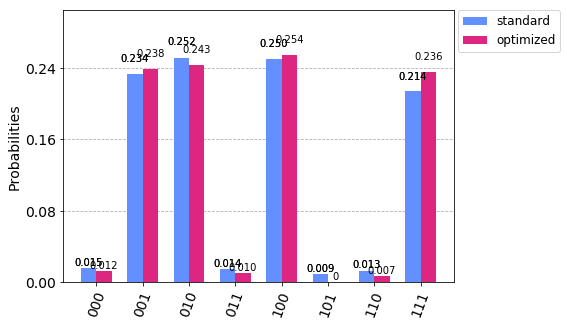

In [26]:
from qiskit.visualization import plot_histogram
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'])

In [27]:
ideal_counts = {'001': 0.25, '010': 0.25, '100': 0.25, '111': 0.25}  # https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B1%2C1%2C%22Z%5E-%C2%BD%22%5D%2C%5B1%2C%22H%22%2C%22H%22%5D%2C%5B1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C%22Z%5E%C2%BD%22%5D%2C%5B1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C%22H%22%5D%2C%5B1%2C1%2C%22Z%5E%C2%BD%22%5D%2C%5B%22Z%5E-%C2%BD%22%5D%2C%5B%22H%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22Z%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22H%22%2C%22H%22%5D%2C%5B%22Z%5E%C2%BD%22%5D%5D%2C%22init%22%3A%5B1%2C1%2C1%5D%7D
# standard_counts =
# optimized_counts = {'00': 3.2117147307346117e-09, '01': 4201.575210406215, '10': 3798.4247895903336, '11': 2.401224165590816e-10}

In [28]:
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, optimized_counts))

0.05489679202662076
0.029723549966152524


In [29]:
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, optimized_counts))

1.4411911531465114
1.4160179110860431


In [30]:
from qiskit.quantum_info import hellinger_fidelity
print(hellinger_fidelity(ideal_counts, standard_counts))
print(hellinger_fidelity(ideal_counts, optimized_counts))

0.8370469293021144
0.8789601928909436
